In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import torch
import kornia as K
import kornia.geometry.transform as tf
import matplotlib.pyplot as plt
from loftr import LoFTR, utils

ModuleNotFoundError: No module named 'loftr'


0: 608x800 1 Vehicle_registration_plate, 598.2ms
Speed: 6.9ms preprocess, 598.2ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 800)
margin_x 26.8
margin_y 19.0
Найденные точки углов номерного знака: [[        8.2          53]
 [      259.8          53]
 [      259.8         137]
 [        8.2         137]]


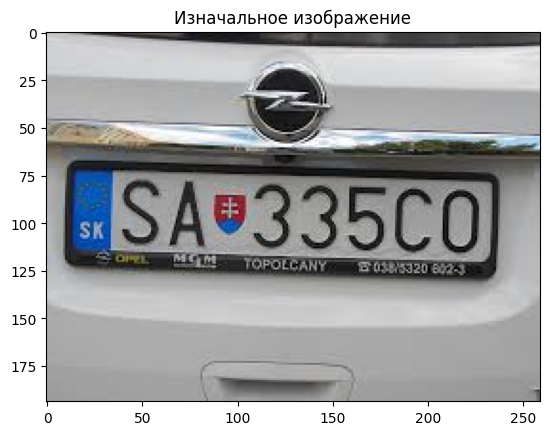

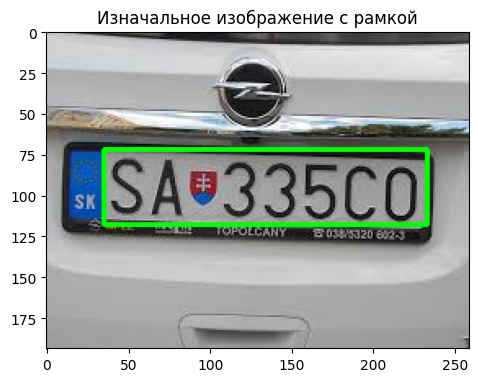

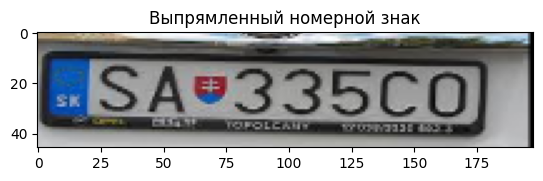

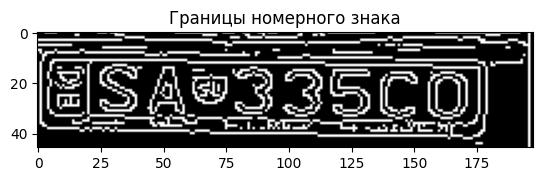

In [ ]:
# Загрузка модели YOLOv8
model = YOLO('best_licence_plate.pt')  # Используйте вашу модель

# Загрузка изображения
image = cv2.imread('images.jpeg')

# Детектирование объектов с помощью YOLOv8
results = model.predict(image)
# Копия изображения для отрисовки рамки
image_with_bbox = image.copy()
# Преобразование результатов в формат для удобной работы
predictions = results[0]  # Получаем первую часть результатов (для одного изображения)

# Проверяем, что предсказания не пусты
if len(predictions.boxes) > 0:
    # Перебор всех предсказаний
    for box in predictions.boxes:
        label = predictions.names[int(box.cls)]  # Получаем метку класса
        
        # Проверяем метку предсказания
        if label == 'Vehicle_registration_plate':  # Проверяем, что метка соответствует 'Vehicle_registration_plate'
            # Получение координат ограничивающего прямоугольника
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])  # Используем координаты верхнего левого и нижнего правого углов
            margin_x=(x_min+x_max)*0.2/2
            print('margin_x',margin_x)
            margin_y=(y_min+y_max)*0.2/2
            print('margin_y',margin_y)

            cv2.rectangle(image_with_bbox, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            # Извлечение углов номерного знака
            points = np.array([
                [x_min-margin_x, y_min-margin_y],  # Верхний левый
                [x_max+margin_x, y_min-margin_y],  # Верхний правый
                [x_max+margin_x, y_max+margin_y],  # Нижний правый
                [x_min-margin_x, y_max+margin_y]   # Нижний левый
            ], dtype="float32")
            print("Найденные точки углов номерного знака:", points)
            # без маржина
            # points = np.array([
            #     [x_min, y_min],  # Верхний левый
            #     [x_max, y_min],  # Верхний правый
            #     [x_max, y_max],  # Нижний правый
            #     [x_min, y_max]   # Нижний левый
            # ], dtype="float32")
            # print("Найденные точки углов номерного знака:", points)

            # Точки назначения для выпрямленного изображения
            width = int(x_max - x_min)
            height = int(y_max - y_min)
            destination_points = np.array([
                [0, 0],
                [width - 1, 0],
                [width - 1, height - 1],
                [0, height - 1]
            ], dtype="float32")
            
            # Построение матрицы гомографии
            matrix = cv2.getPerspectiveTransform(points, destination_points)

            # Преобразование изображения
            warped = cv2.warpPerspective(image, matrix, (width, height))

            # Сохранение результирующего изображения
            #cv2.imwrite('straightened_plate.jpg', warped)
            #print("Изображение номерного знака выпрямлено и сохранено.")

            gray_plate = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(warped, 50, 150)

            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Конвертируем в RGB перед отображением
            plt.title('Изначальное изображение')
            plt.show()

            # Отображение изначального изображения с рамкой
            plt.figure(figsize=(12, 6))  # Задаем размер изображения для отображения
            plt.subplot(1, 2, 1)  # Делаем подложку для двух изображений
            plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
            plt.title('Изначальное изображение с рамкой')
            plt.show()

            plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))  # Конвертируем в RGB перед отображением
            plt.title('Выпрямленный номерной знак')
            plt.show()

            plt.imshow(edges, cmap='gray')  # Отображаем границы
            plt.title('Границы номерного знака')
            plt.show()

            # Выход из цикла после обработки первого найденного номерного знака
            break
else:
    print("Номерной знак не обнаружен.")

## корниа

In [ ]:
# Загрузка изображения с помощью OpenCV
image = cv2.imread('images.jpeg')  # [H, W, C]

# Проверка размеров изображения
print("Shape of the original image:", image.shape)  # Должен быть [H, W, C]

# Конвертация изображения в формат тензора PyTorch и нормализация
image_tensor = K.image_to_tensor(image, keepdim=False).float() / 255.0  # [C, H, W]

# Проверка размеров тензора
print("Shape of the tensor:", image_tensor.shape)  # Должен быть [1, C, H, W]

# # Предполагаем, что у нас есть координаты углов номерного знака
# x_min, y_min, x_max, y_max = 50, 50, 200, 100  # Примерные координаты

# # Определение исходных точек на изображении (углы номерного знака)
# points = np.array([
#     [x_min, y_min],  # Верхний левый
#     [x_max, y_min],  # Верхний правый
#     [x_max, y_max],  # Нижний правый
#     [x_min, y_max]   # Нижний левый
# ], dtype=np.float32)

# Точки назначения для выпрямленного изображения
width = int(x_max - x_min)
height = int(y_max - y_min)
destination_points = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype=np.float32)

# Преобразование numpy массивов в тензоры
src_points = torch.tensor(points).unsqueeze(0)  # Добавляем размер batch, теперь [1, 4, 2]
dst_points = torch.tensor(destination_points).unsqueeze(0)  # Добавляем размер batch, теперь [1, 4, 2]
print(src_points.shape)
print(dst_points.shape)
# Вычисление матрицы гомографии
homography_matrix = K.geometry.transform.get_perspective_transform(src_points, dst_points)  # [1, 3, 3]
print(f'homomatrix {homography_matrix.shape}')
print(image.shape)
print(image_tensor.shape)
# Преобразование изображения с использованием перспективной трансформации
warped_image_tensor = tf.warp_perspective(image_tensor, homography_matrix, dsize=(height, width))  # [1, C, H, W]

# Проверка размеров результирующего тензора
print("Shape of the warped tensor:", warped_image_tensor.shape)  # Должен быть [1, C, H, W]

# Преобразование тензора обратно в изображение
warped_image = K.tensor_to_image(warped_image_tensor.squeeze(0))  # Убираем размер batch, теперь [C, H, W]

# Сохранение результирующего изображения
cv2.imwrite('straightened_plate_kornia.jpg', (warped_image * 255).astype(np.uint8))
print("Изображение номерного знака выпрямлено и сохранено.")

Shape of the original image: (194, 259, 3)
Shape of the tensor: torch.Size([1, 3, 194, 259])
torch.Size([1, 4, 2])
torch.Size([1, 4, 2])
homomatrix torch.Size([1, 3, 3])
(194, 259, 3)
torch.Size([1, 3, 194, 259])
Shape of the warped tensor: torch.Size([1, 3, 46, 198])
Изображение номерного знака выпрямлено и сохранено.


## клирмл

In [ ]:
from clearml import PipelineDecorator

@PipelineDecorator.component(cache=True, execution_queue="default")
def step(size: int):
    import numpy as np
    return np.random.random(size=size)

@PipelineDecorator.pipeline(
    name='ingest',
    project='data processing',
    version='0.1'
)
def pipeline_logic(do_stuff: bool):
    if do_stuff:
        return step(size=42)

if __name__ == '__main__':
    # run the pipeline on the current machine, for local debugging
    # for scale-out, comment-out the following line (Make sure a
    # 'services' queue is available and serviced by a ClearML agent
    # running either in services mode or through K8S/Autoscaler)
    PipelineDecorator.run_locally()

    pipeline_logic(do_stuff=True)

Retrying (Retry(total=239, connect=239, read=240, redirect=240, status=240)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x120a8a490>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')': /auth.login
Retrying (Retry(total=238, connect=238, read=240, redirect=240, status=240)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x120ad4d90>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')': /auth.login
Retrying (Retry(total=237, connect=237, read=240, redirect=240, status=240)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x120ae46d0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known')': /auth.login
Retrying (Retry(total=236, connect=236, read=240, redirect=240, status=240)) after connection broken by 'NewConnectionErr

KeyboardInterrupt: 

## bilinear interpolation

In [1]:
%pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 821.0 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
from pycocotools.coco import COCO
from PIL import Image, ImageDraw
import numpy as np
import os

In [3]:
with open('/Users/user/virtualenv/hacks/digitalproriv_grozny/licenc_plate/annotations/instances_default.json') as f:
    coco_data = json.load(f)
coco = COCO('/Users/user/virtualenv/hacks/digitalproriv_grozny/licenc_plate/annotations/instances_default.json')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
def crop_objects(image_path, annotation_data, output_dir):
    image = Image.open(image_path)
    image_id = os.path.splitext(os.path.basename(image_path))[0]

    for ann in annotation_data['annotations']:
        if ann['image_id'] == int(image_id):
            mask = coco.annToMask(ann)
            mask = Image.fromarray(mask * 255)

            # Обрезка по маске
            object_image = Image.new("RGBA", image.size)
            object_image.paste(image, mask=mask)

            # Определяем границы обрезки
            bbox = ann['bbox']
            cropped = object_image.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
            
            # Сохранение вырезанного объекта
            cropped.save(os.path.join(output_dir, f"{image_id}_object_{ann['id']}.png"))


In [5]:
os.makedirs('cropped_objects', exist_ok=True)

for img in coco_data['images']:
    img_path = os.path.join('/Users/user/virtualenv/hacks/digitalproriv_grozny/licenc_plate/images', img['file_name'])
    crop_objects(img_path, coco_data, 'cropped_objects')


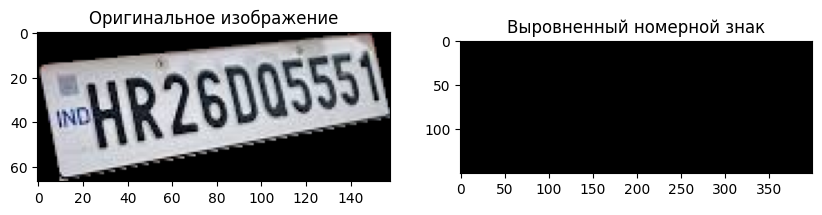

Выровненное изображение сохранено как /Users/user/virtualenv/hacks/digitalproriv_grozny/straightened_image.png


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузить изображение
image_path = "/Users/user/virtualenv/hacks/digitalproriv_grozny/cropped_objects/3_object_3.png"
image = cv2.imread(image_path)

# Преобразование в оттенки серого
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Применить размытие, чтобы улучшить обнаружение контуров
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Обнаружение краев
edges = cv2.Canny(blurred, 50, 200)

# Найти контуры
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Сортируем контуры по площади, чтобы найти самый большой
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Находим контур с 4 углами
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4:
        screenCnt = approx
        break

# Получаем координаты углов
pts = screenCnt.reshape(4, 2)

# Функция для упорядочивания точек в порядке: верхний левый, верхний правый, нижний правый, нижний левый
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

rect = order_points(pts)

# Определим целевые координаты для выравнивания
(width, height) = (400, 150)  # Размеры прямоугольного шаблона

dst = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]], dtype="float32")

# Применяем перспективное преобразование
M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(image, M, (width, height))

# Сохраняем и выводим изображение
output_path = "/Users/user/virtualenv/hacks/digitalproriv_grozny/straightened_image.png"
cv2.imwrite(output_path, warped)

# Отображение результата
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Выровненный номерной знак")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

print(f"Выровненное изображение сохранено как {output_path}")


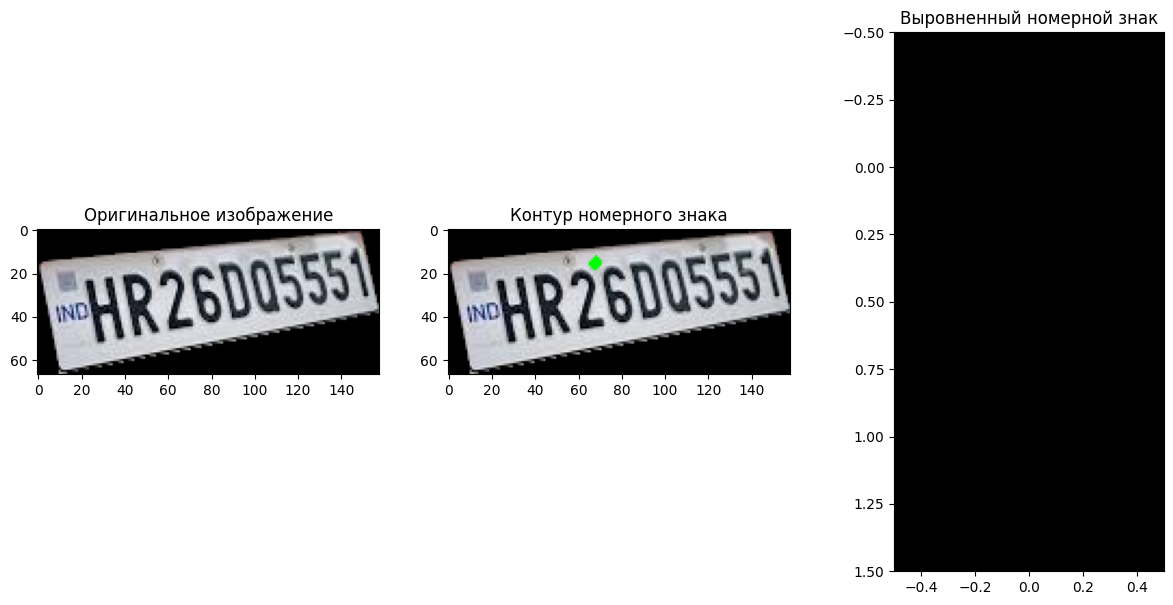

Выровненное изображение сохранено как /Users/user/virtualenv/hacks/digitalproriv_grozny/jopa.png


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузить изображение
image_path = "/Users/user/virtualenv/hacks/digitalproriv_grozny/cropped_objects/3_object_3.png"
image = cv2.imread(image_path)

# Преобразование в оттенки серого
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Применить размытие для устранения шума
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Адаптивный порог для улучшения выделения контуров
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# Инвертируем изображение для улучшения выделения
thresh = cv2.bitwise_not(thresh)

# Найти контуры
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Найти контур с максимальной площадью, подходящий для номерного знака
screenCnt = None
max_area = 0

for contour in contours:
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
    
    if len(approx) == 4:
        area = cv2.contourArea(approx)
        if area > max_area:
            screenCnt = approx
            max_area = area

if screenCnt is None:
    print("Номерной знак не найден.")
else:
    # Рисуем найденный контур для проверки
    result = image.copy()
    cv2.drawContours(result, [screenCnt], -1, (0, 255, 0), 3)

    # Получаем координаты углов
    pts = screenCnt.reshape(4, 2)

    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        return rect

    rect = order_points(pts)

    # Определяем целевые координаты
    width = max(int(np.linalg.norm(rect[1] - rect[0])), int(np.linalg.norm(rect[2] - rect[3])))
    height = max(int(np.linalg.norm(rect[3] - rect[0])), int(np.linalg.norm(rect[2] - rect[1])))

    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]], dtype="float32")

    # Применяем перспективное преобразование
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (width, height))

    # Сохраняем и выводим изображение
    output_path = "/Users/user/virtualenv/hacks/digitalproriv_grozny/jopa.png"
    cv2.imwrite(output_path, warped)

    # Отображение результата
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.title("Оригинальное изображение")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 2)
    plt.title("Контур номерного знака")
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 3)
    plt.title("Выровненный номерной знак")
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    plt.show()

    print(f"Выровненное изображение сохранено как {output_path}")


## EasyOCR

In [1]:
%pip install easyocr

Note: you may need to restart the kernel to use updated packages.


In [1]:
import easyocr
import cv2
import matplotlib.pyplot as plt

In [2]:
reader = easyocr.Reader(['en']) 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


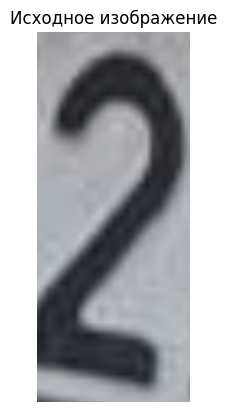

In [15]:
image_path = '/Users/user/virtualenv/hacks/digitalproriv_grozny/Снимок экрана 2024-07-06 в 17.45.46.png'  # Замените на путь к вашему изображению
image = cv2.imread(image_path)
#image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Отображение исходного изображения
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

In [16]:
results = reader.readtext(image_path, detail=1,allowlist='1234567890ABEKMHOPCTYX')

Обнаруженный текст: 2, Вероятность: 0.9999995231628986
Координаты границ текста: [[0, 15], [202, 15], [202, 469], [0, 469]]


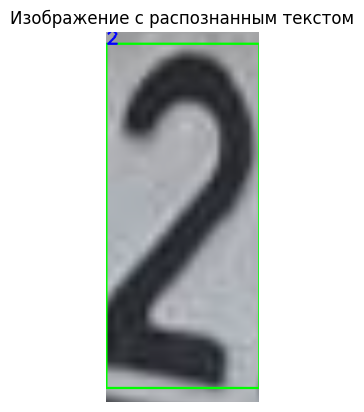

In [17]:
for (bbox, text, prob) in results:
    text=text[:8]
    print(f"Обнаруженный текст: {text}, Вероятность: {prob}")
    print(f"Координаты границ текста: {bbox}")

# Визуализация результатов
for (bbox, text, prob) in results:
    # Координаты границ
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))

    # Рисуем рамку вокруг текста
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    cv2.putText(image, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# Отображение изображения с распознанным текстом
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Изображение с распознанным текстом')
plt.axis('off')
plt.show()


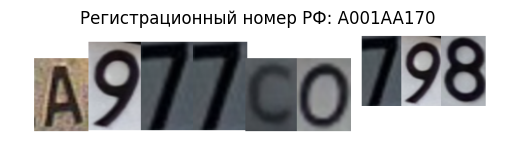

Изображение сохранено по пути: russian_license_plate_custom_A977CO798.png


In [18]:
from PIL import Image, ImageDraw
import os

# Размеры шаблона
template_width = 512
template_height = 112
background_color = 'white'

# Путь к папке с изображениями символов
symbols_folder = "/Users/user/virtualenv/hacks/digitalproriv_grozny/numbers"

# Номер для размещения
number = "A977CO798"

# Создание шаблона
template = Image.new('RGB', (template_width, template_height), background_color)
draw = ImageDraw.Draw(template)

# Загрузка и размещение символов
def place_symbol(image_path, position):
    symbol_image = Image.open(image_path)
    symbol_image = symbol_image.resize((int(position['width']), int(position['height'])))
    template.paste(symbol_image, (int(position['x']), int(position['y'])))

# Определение позиций символов на шаблоне
symbol_positions = [
    {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
    {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
    {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
    {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
    {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
    {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
    {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
    {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
    {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
]

# Размещение каждого символа на шаблоне
for symbol_index, char in enumerate(number):
    for pos_info in symbol_positions:
        if pos_info['pos'] == symbol_index + 1:  # pos starts from 1, symbol_index starts from 0
            p1_x, p1_y = pos_info['p1'][0] * template_width, pos_info['p1'][1] * template_height
            p2_x, p2_y = pos_info['p2'][0] * template_width, pos_info['p2'][1] * template_height
            symbol_width = p2_x - p1_x
            symbol_height = p2_y - p1_y
            
            # Загрузка и масштабирование изображения символа
            image_path = os.path.join(symbols_folder, f"{char}.png")
            symbol_image = Image.open(image_path)
            symbol_image = symbol_image.resize((int(symbol_width), int(symbol_height)))
            
            # Размещение символа на шаблоне
            template.paste(symbol_image, (int(p1_x), int(p1_y)))

# Сохранение изображения
output_path = f'russian_license_plate_custom_{number}.png'
template.save(output_path)

# Отображение изображения
plt.imshow(template)
plt.axis('off')
plt.title("Регистрационный номер РФ: A001AA170")
plt.show()


print(f"Изображение сохранено по пути: {output_path}")


In [2]:
import cv2
import easyocr
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

In [13]:
# Папки с изображениями и аннотациями
images_folder = "/Users/user/Downloads/1numberanno/JPEGImages"
annotations_folder = "/Users/user/Downloads/1numberanno/Annotations"

In [14]:
reader = easyocr.Reader(['en'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [15]:
def extract_rois_from_voc(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    rois = []

    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = round(float(bndbox.find('xmin').text))
        ymin = round(float(bndbox.find('ymin').text))
        xmax = round(float(bndbox.find('xmax').text))
        ymax = round(float(bndbox.find('ymax').text))
        rois.append((xmin, ymin, xmax, ymax))

    return rois

# Функция для обработки изображения и аннотации
def process_image_and_annotation(image_path, annotation_path):
    results = []

    # Извлечение ROI из аннотации
    rois = extract_rois_from_voc(annotation_path)

    # Открытие изображения
    image = Image.open(image_path)

    # Обработка каждого ROI
    for (xmin, ymin, xmax, ymax) in rois:
        # Вырезание ROI
        roi = image.crop((xmin, ymin, xmax, ymax))

        # Преобразование ROI в формат, поддерживаемый EasyOCR
        roi_array = cv2.cvtColor(np.array(roi), cv2.COLOR_RGB2BGR)

        # Распознавание текста в ROI
        ocr_results = reader.readtext(roi_array, allowlist='1234567890ABEKMHOPCTYX')

        for bbox, text, prob in ocr_results:
            results.append(text)

    # Склеивание всех распознанных текстов в одну строку
    final_result = ''.join(results)

    return final_result

# Запуск обработки для конкретного файла
final_result = process_image_and_annotation(image_path, annotation_path)

# Вывод результата
print("Итоговый распознанный номер:", final_result)

Итоговый распознанный номер: 5


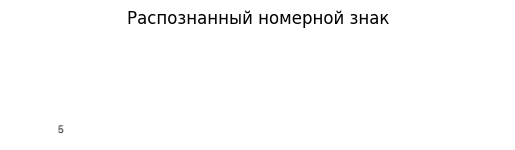

In [16]:
# Визуализация результата
template_width = 512
template_height = 112
background_color = 'white'
template = Image.new('RGB', (template_width, template_height), background_color)
draw = ImageDraw.Draw(template)

# Координаты для размещения символов на шаблоне
three_digit_region_template = [
    {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
    {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
    {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
    {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
    {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
    {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
    {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
    {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
    {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
]

# Размещение распознанных символов на шаблоне
for i, char in enumerate(final_result):
    if i < len(three_digit_region_template):
        coords = three_digit_region_template[i]
        p1_x, p1_y = int(coords['p1'][0] * template_width), int(coords['p1'][1] * template_height)
        p2_x, p2_y = int(coords['p2'][0] * template_width), int(coords['p2'][1] * template_height)
        
        # Определение высоты и ширины текста
        text_bbox = draw.textbbox((0, 0), char, font=None)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Центрирование текста в пределах квадрата
        text_x = p1_x + (p2_x - p1_x - text_width) // 2
        text_y = p2_y - text_height

        # Рисуем текст
        draw.text((text_x, text_y), char, fill='black')

# Сохранение изображения
output_image_path = 'final_number_plate.png'
template.save(output_image_path)

# Отображение изображения
plt.imshow(template)
plt.axis('off')
plt.title('Распознанный номерной знак')
plt.show()